In [1]:
import numpy as np
import pandas as pd
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
data_full = pd.read_csv( '../01-data/data_merged_20220910_norm.csv')
data_full = data_full.query( 'H_Age<100&Draw>0')
# data_full = data_full[ data_full[ 'Place'] < 11]
# data_full = data_full[ data_full[ 'RaceYear'] > 2020]
# data_full.info( verbose = True)
X = data_full.loc[ :, data_full.columns.str.startswith( 'ActualWeight') | data_full.columns.str.startswith( 'DeclaredHorseWeight') | \
    data_full.columns.str.startswith( 'WinOdds') | data_full.columns.str.startswith( 'Draw') | \
    data_full.columns.str.startswith( 'J_Total_') | data_full.columns.str.startswith( 'J_TotalStakes_') | \
    data_full.columns.str.startswith( 'J_Rate_') | \
    data_full.columns.str.startswith( 'T_Total_') | data_full.columns.str.startswith( 'T_TotalStakes_') | \
    data_full.columns.str.startswith( 'T_Rate') | \
    data_full.columns.str.startswith( 'H_Rate_') | data_full.columns.str.startswith( 'H_Total') | \
    data_full.columns.str.startswith( 'H_TotalStake') | data_full.columns.str.startswith( 'CombinedRating') | \
    data_full.columns.str.startswith( 'H_Age') | data_full.columns.str.startswith( 'WeightDiff') | \
    data_full.columns.str.startswith( 'LastRace_nDays') | data_full.columns.str.startswith( 'PreviousPlace') | \
    data_full.columns.str.startswith( 'AvgPlace3') | data_full.columns.str.startswith( 'AvgPlace5') | \
    data_full.columns.str.startswith( 'Place')] # Place is added for downsampling

print( X.columns)
y = data_full[ 'Winner']

Index(['Place', 'ActualWeight', 'DeclaredHorseWeight', 'Draw', 'WinOdds',
       'J_Rate_win', 'J_Rate_place', 'J_Rate_show', 'T_Rate_win',
       'T_Rate_place', 'T_Rate_show', 'H_TotalStake', 'H_Total', 'H_Rate_win',
       'H_Rate_place', 'H_Rate_show', 'H_Age', 'LastRace_nDays',
       'PreviousPlace', 'AvgPlace3', 'AvgPlace5', 'WeightDiff',
       'CombinedRating', 'Place_norm', 'ActualWeight_norm',
       'DeclaredHorseWeight_norm', 'Draw_norm', 'WinOdds_norm',
       'J_Rate_win_norm', 'J_Rate_place_norm', 'J_Rate_show_norm',
       'T_Rate_win_norm', 'T_Rate_place_norm', 'T_Rate_show_norm',
       'H_TotalStake_norm', 'H_Total_norm', 'H_Rate_win_norm',
       'H_Rate_place_norm', 'H_Rate_show_norm', 'H_Age_norm',
       'LastRace_nDays_norm', 'PreviousPlace_norm', 'AvgPlace3_norm',
       'AvgPlace5_norm', 'WeightDiff_norm', 'CombinedRating_norm'],
      dtype='object')


/var/folders/cp/sy05qy250mg99nnwmfjffrwh0000gn/T/ipykernel_2156/3758491241.py:1: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  data_full = pd.read_csv( '../01-data/data_merged_20220910_norm.csv')


In [3]:
print( y.value_counts())

False    15038
True      1355
Name: Winner, dtype: int64


# Exploratory analysis

Exploratory analysis is performed on (1) actual weight, (2) declared horse weight, (3) draw, (4) Win odds, (5) jockey’s win rate, (6) jockey’s place rate, (7) jockey’s show rate, (8) trainer’s win rate, (9) trainer’s place rate, (10) trainer’s show rate, (11) total stake the horse has earned, (12) total race the horse has run, (13) horse’s win rate, (14) horse’s place rate, (15) horse’s show rate, (16) horse age, (17) number of days since last race, (18) place in the previous race, (19) average place in the previous 3 races, (20) average place in the previous 5 races, (21) chang in horse weight since the last race, (22) rating.

### Actual Weight

In [4]:
def EDA( variable, text, size = 50, height = 200):
    global data_full
    bar = alt.Chart( data_full, title = f'Distribution of {text}').mark_bar().encode(
    x = alt.X( variable, bin = alt.Bin( maxbins = 30), title = f'{text}'),
    y = 'count()'
    ).properties(
        height = height,
        width = 200
    )

    box = alt.Chart( data_full, title = f'Distribution of {text} by Class').mark_boxplot( size = size).encode(
        x = alt.X( variable, scale = alt.Scale( zero = False), title = f'{text}'),
        y = 'Winner',
        color = 'Winner'
    ).properties(
        height = height,
        width = 200
    )

    data_full[ f'{variable}_bin'] = pd.qcut( data_full[ variable], q = 10, labels = False, duplicates = 'drop')
    df_tmp = data_full[ [ f'{variable}_bin', 'Winner']].groupby( f'{variable}_bin').mean()

    bin_ = alt.Chart( df_tmp.reset_index(), title = f'Effect of {text} on % on Winning').mark_bar().encode(
        x = alt.X( f'{variable}_bin:O', title = f'Percentiles of {text}'),
        y = alt.Y( 'Winner', title = 'Chance of Wining')
    ).properties(
        height = height,
        width = 200
    )

    return ( bar | box | bin_)

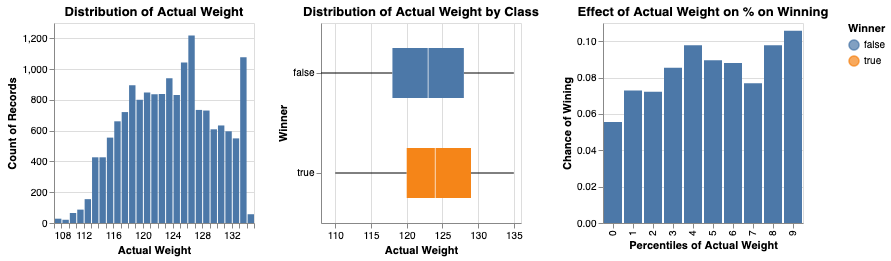

In [5]:
EDA( variable = 'ActualWeight', text = 'Actual Weight')

Actual weight is slight negatively skewed with low kurtosis. The difference in actual weight between winners and non-winners is not visually obvious. Still, the boxplot shows that winners have slightly heavier actual weight to be carried. After binning the actual weights of each horses, it can be seen that those with large weights are more likely to win. Standard scaling will be applied to this variable.

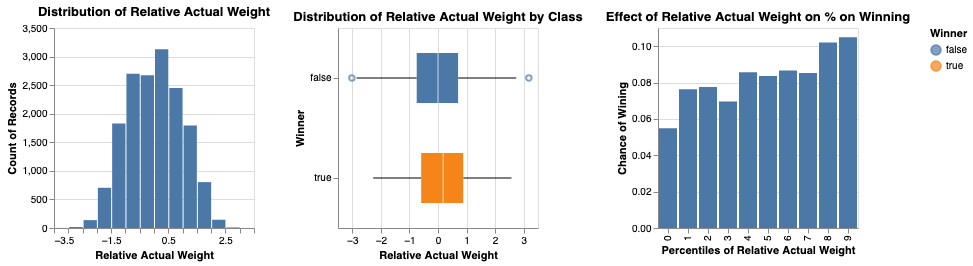

In [6]:
EDA( variable = 'ActualWeight_norm', text = 'Relative Actual Weight')

Relative acutal weight is more normally distributed. From the boxplot, it is hard to determine whether it differs in winners and non-winners. The final bar chart shows that those with higher relative actual weights seem to have higher chance to win a race. No scaling will be used on this variable as it is already normalized.

### Declared Horse Weight

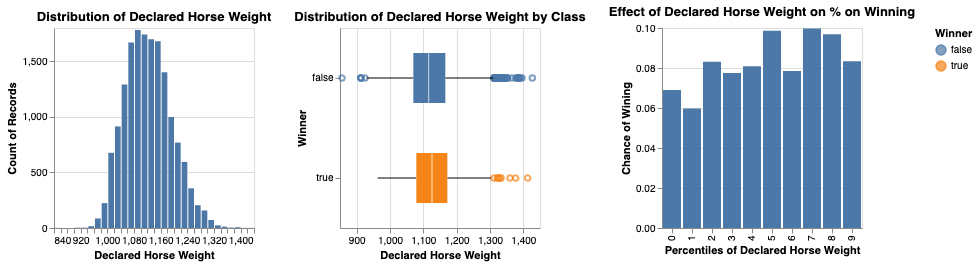

In [7]:
EDA( variable = 'DeclaredHorseWeight', text = 'Declared Horse Weight')

By visual insepection, it is not likely that declared horse weight will be an effective feature in predicting winners

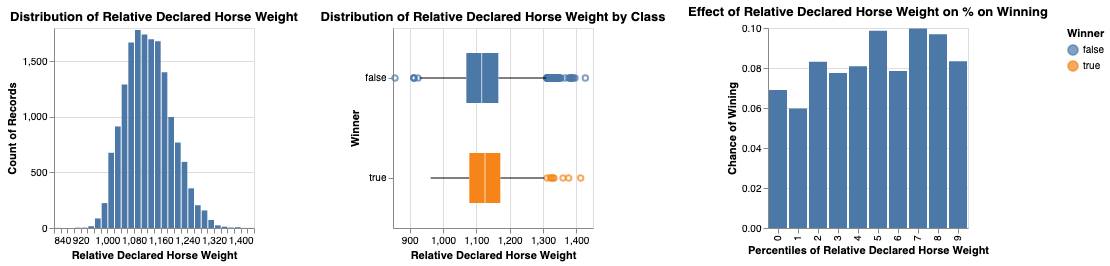

In [8]:
EDA( variable = 'DeclaredHorseWeight', text = 'Relative Declared Horse Weight')

By visual insepection, it is not likely that relative declared horse weight will be an effective feature in predicting winners

## Draw

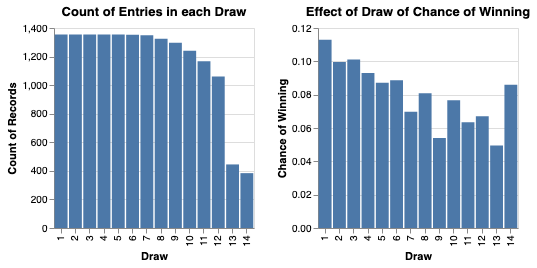

In [9]:
count_ = alt.Chart( data_full, title = 'Count of Entries in each Draw').mark_bar().encode(
    x = 'Draw:O',
    y = 'count()'
).properties(
    height = 200,
    width = 200)

prob_draw = data_full[ data_full[ 'Winner'] == True][ 'Draw'].value_counts() / data_full[ 'Draw'].value_counts()
prob_draw = prob_draw.reset_index()

chance_ = alt.Chart( prob_draw, title = 'Effect of Draw of Chance of Winning').mark_bar().encode(
    x = alt.X( 'index:O', title = 'Draw'),
    y = alt.Y( 'Draw', title = 'Chance of Winning')
).properties(
    height = 200,
    width = 200)

count_ | chance_

It can be seen that draw number may have a effect on the chance of winning. It is also noted that the distribution of draw number in the data is not even. It is because some of the races have fewer horses and only a limited number of races are with more than 12 horses. Although it is an ordinal variable, this feature will be scaled with standard scaler as models will be sensitive to scales.

### Win Odds

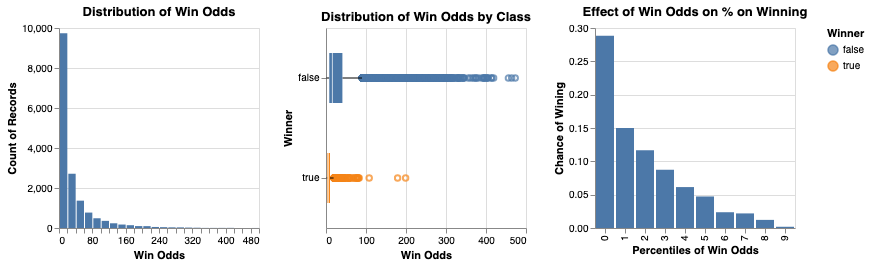

In [10]:
EDA( variable = 'WinOdds', text = 'Win Odds')

While the variable is highly positively skewed, logarithmaic transformation will be applied.

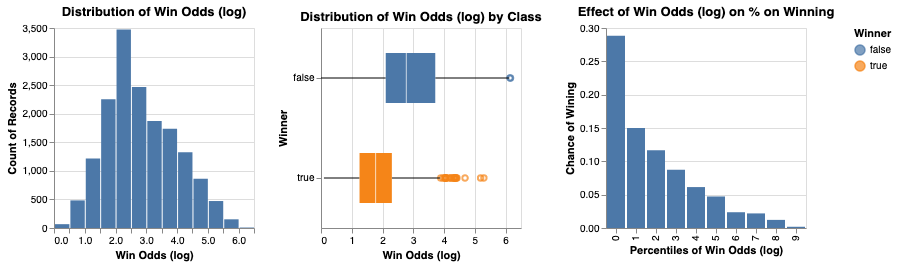

In [11]:
data_full[ 'log_WinOdds'] = np.log( data_full[ 'WinOdds'])
data_full.loc[ data_full[ 'log_WinOdds'] == -np.inf, 'log_WinOdds'] = 0

EDA( variable = 'log_WinOdds', text = 'Win Odds (log)')

Win odds after logarithmic transformation appears to be more normally distributed and it is obvious that smaller odds are associated with higher chance of winning. This feature will be scaled by a standard scaler.

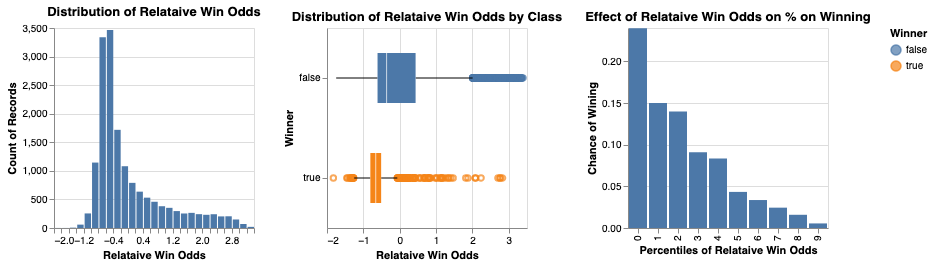

In [12]:
EDA( variable = 'WinOdds_norm', text = 'Relataive Win Odds')

While the relative score appears to be skewed, it will not be further transformed as it is normalized theoretically. It can be seen that the relative win odd can also potentially predict winners.

### Jockey's rate of winning

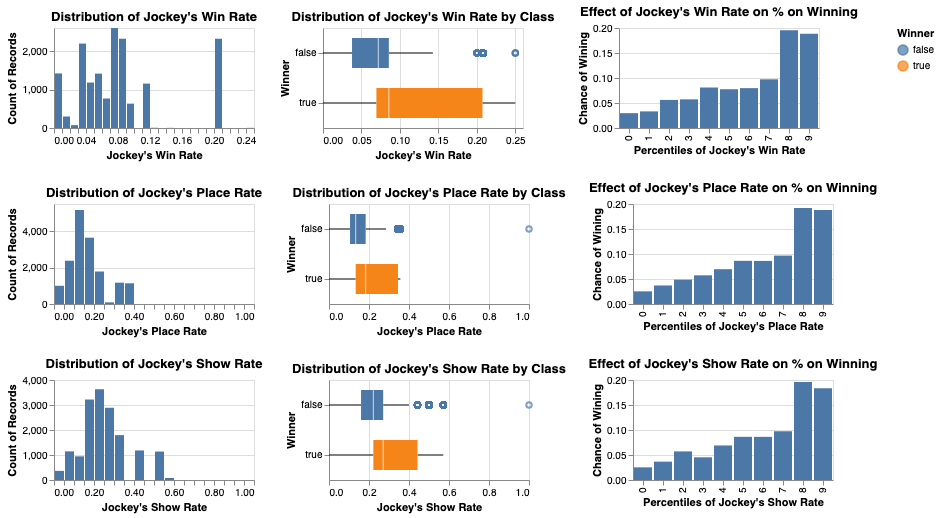

In [13]:
EDA( variable = 'J_Rate_win', text = 'Jockey\'s Win Rate', size = 30, height = 100) & (
    EDA( variable = 'J_Rate_place', text = 'Jockey\'s Place Rate', size = 30, height = 100)) & (
        EDA( variable = 'J_Rate_show', text = 'Jockey\'s Show Rate', size = 30, height = 100))

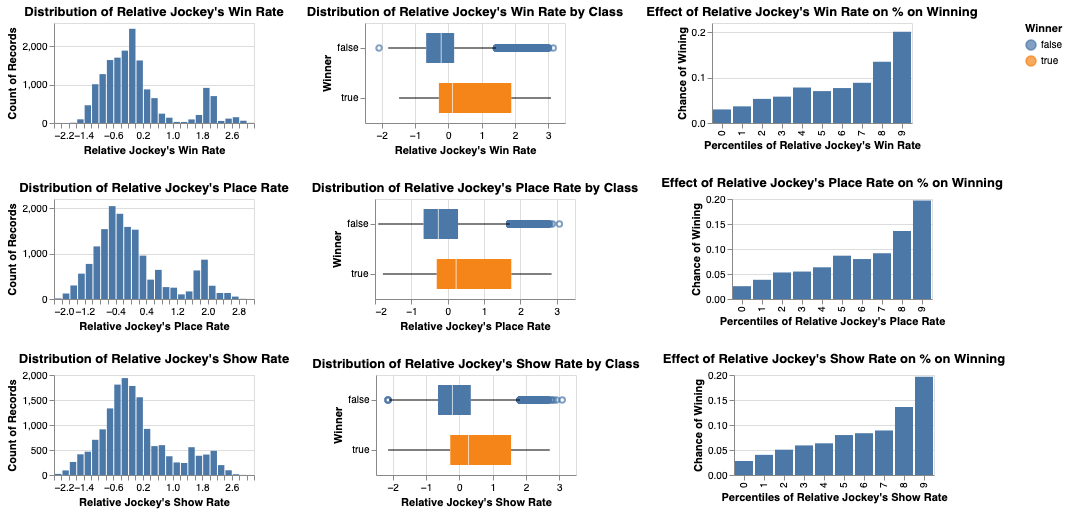

In [14]:
EDA( variable = 'J_Rate_win_norm', text = 'Relative Jockey\'s Win Rate', size = 30, height = 100) & (
    EDA( variable = 'J_Rate_place_norm', text = 'Relative Jockey\'s Place Rate', size = 30, height = 100)) & (
        EDA( variable = 'J_Rate_show_norm', text = 'Relative Jockey\'s Show Rate', size = 30, height = 100))

It should not be a surprise that Jockeys' rates of winning (1st, 2nd, 3rd) is associated with whehther an entry can win a race or not. This feature will not be further scaled as it is already bounded between 0 and 1. However, it should be noted that this feature may not be practical in real life prediction as the winning rates are fetched at the end of the season. Thus, these features already stored whether a jockey has been winning in the past, but may not signal their performance in the feature.

### Trainer's rate of winning

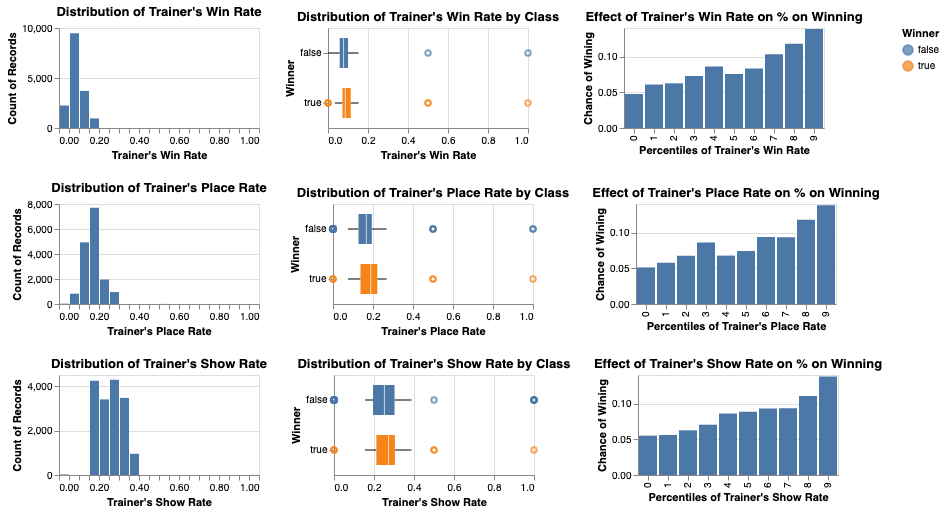

In [15]:
EDA( variable = 'T_Rate_win', text = 'Trainer\'s Win Rate', size = 30, height = 100) & (
    EDA( variable = 'T_Rate_place', text = 'Trainer\'s Place Rate', size = 30, height = 100)) & (
        EDA( variable = 'T_Rate_show', text = 'Trainer\'s Show Rate', size = 30, height = 100))

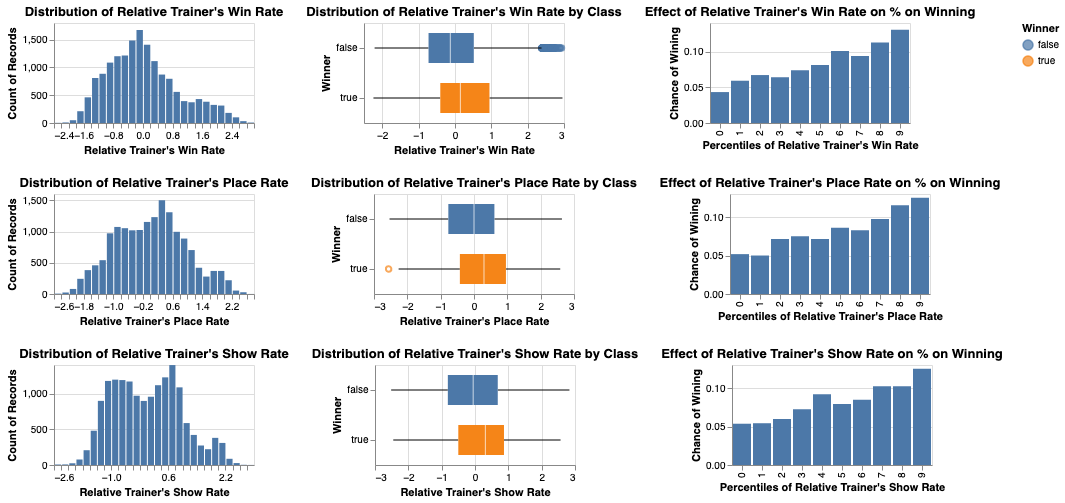

In [16]:
EDA( variable = 'T_Rate_win_norm', text = 'Relative Trainer\'s Win Rate', size = 30, height = 100) & (
    EDA( variable = 'T_Rate_place_norm', text = 'Relative Trainer\'s Place Rate', size = 30, height = 100)) & (
        EDA( variable = 'T_Rate_show_norm', text = 'Relative Trainer\'s Show Rate', size = 30, height = 100))

The distributions of winning rates are not smooth because there is only a few trainers, compared to the large amount of races and hores entries. From visual inspection, it is seen that trainers' winning rates are not effective in predicting winners. It is decided that no scaling will be performed as this variable is bounded between 0 and 1.

### Total Stake by the Horse

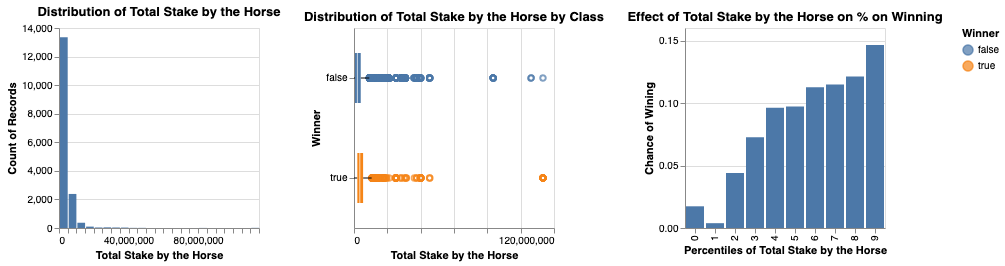

In [17]:
EDA( variable = 'H_TotalStake', text = 'Total Stake by the Horse')

Logarithmic transformation is performed as the distribution is highly positively skewed.

/opt/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


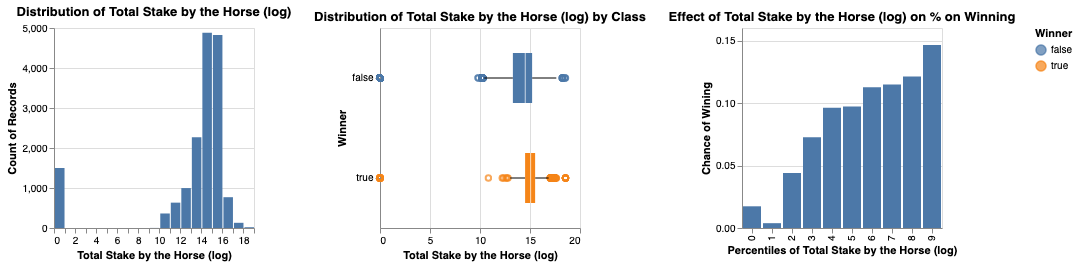

In [18]:
data_full[ 'log_H_TotalStake'] = np.log( data_full[ 'H_TotalStake'])
data_full.loc[ data_full[ 'log_H_TotalStake'] == -np.inf, 'log_H_TotalStake'] = 0
EDA( variable = 'log_H_TotalStake', text = 'Total Stake by the Horse (log)')

It is seen that winners have higher total stake earned. Standard scaling will be used for this feature.

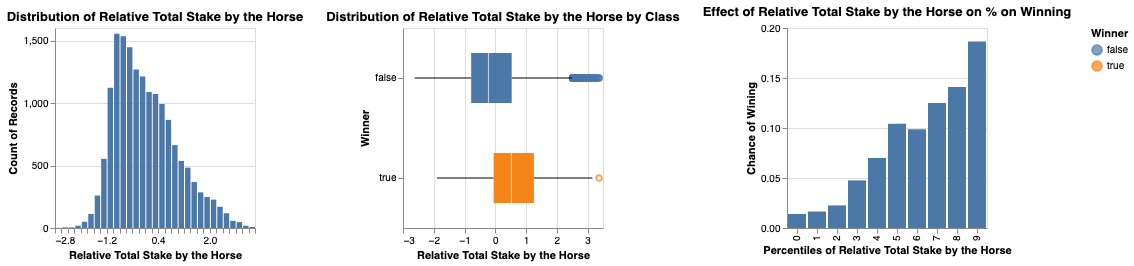

In [19]:
EDA( variable = 'H_TotalStake_norm', text = 'Relative Total Stake by the Horse')

By visual insepction, it is observed that relative stake earned by the horse can be used to predict winners effectively.

### Horses' 

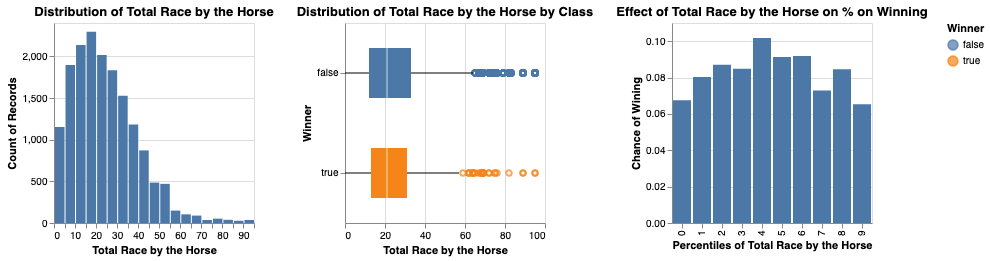

In [20]:
EDA( variable = 'H_Total', text = 'Total Race by the Horse')

We attempt to test whether a logrithmatic transformation will reduce the skewness of the distribution.

/opt/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


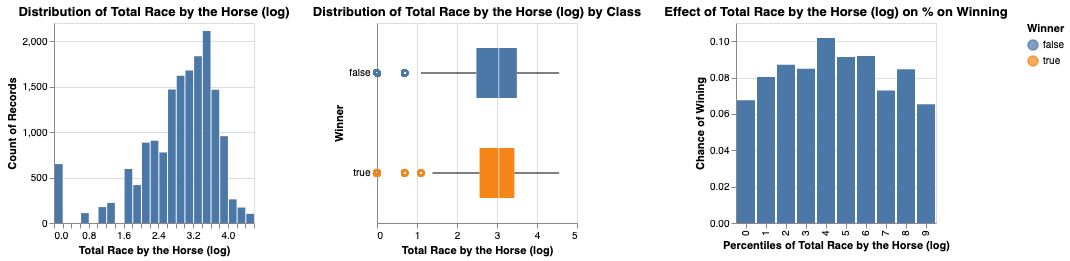

In [21]:
data_full[ 'log_H_Total'] = np.log( data_full[ 'H_Total'])
data_full.loc[ data_full[ 'log_H_Total'] == -np.inf, 'log_H_Total'] = 0
EDA( variable = 'log_H_Total', text = 'Total Race by the Horse (log)')

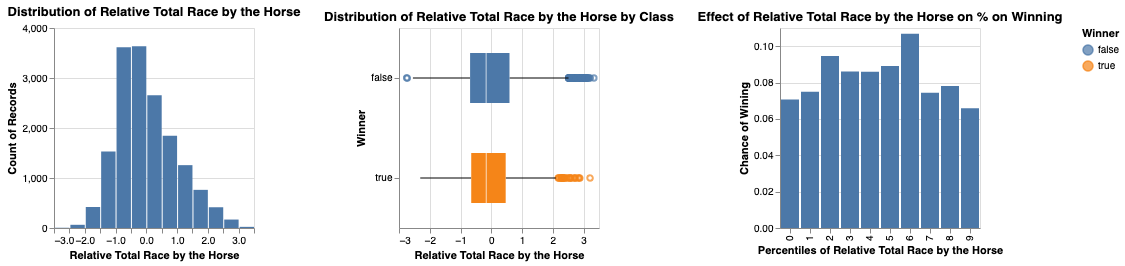

In [22]:
EDA( variable = 'H_Total_norm', text = 'Relative Total Race by the Horse')

The total number of race a horse has participated may not be an effective predictor of winners. If this feature is decided to be used in the model, standard scaling will be performed.

### Horses' Winning Rates

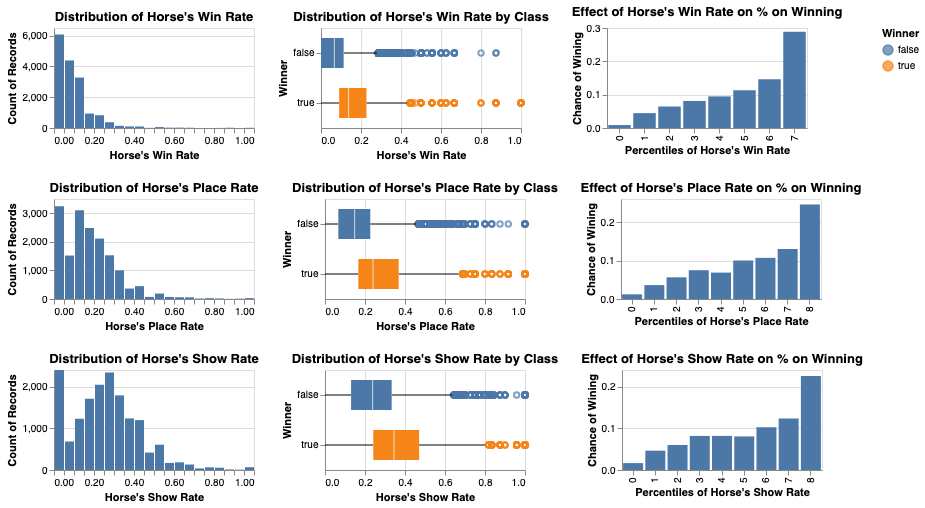

In [23]:
EDA( variable = 'H_Rate_win', text = 'Horse\'s Win Rate', size = 30, height = 100) & (
    EDA( variable = 'H_Rate_place', text = 'Horse\'s Place Rate', size = 30, height = 100)) & (
        EDA( variable = 'H_Rate_show', text = 'Horse\'s Show Rate', size = 30, height = 100))

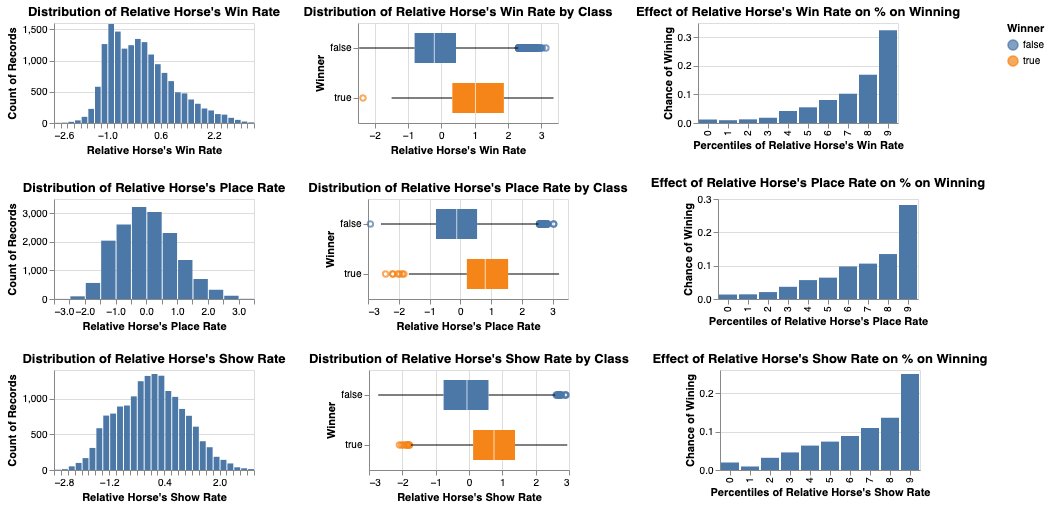

In [24]:
EDA( variable = 'H_Rate_win_norm', text = 'Relative Horse\'s Win Rate', size = 30, height = 100) & (
    EDA( variable = 'H_Rate_place_norm', text = 'Relative Horse\'s Place Rate', size = 30, height = 100)) & (
        EDA( variable = 'H_Rate_show_norm', text = 'Relative Horse\'s Show Rate', size = 30, height = 100))

Horses' winning rates may be effective in predicting winners. However, similar to jockeys' and trainers' winning rates, this feature may not be realistically practical due to the timing of data collection.

### Horse Age

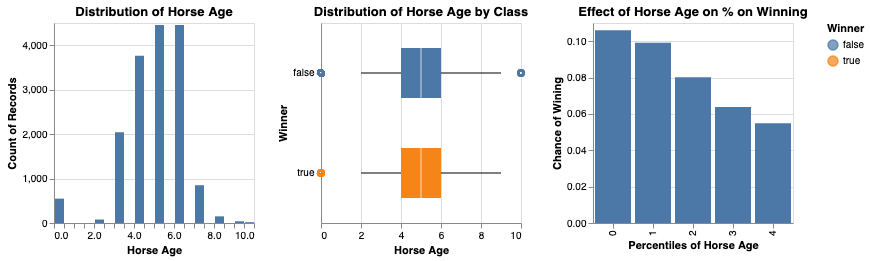

In [25]:
EDA( variable = 'H_Age', text = 'Horse Age')

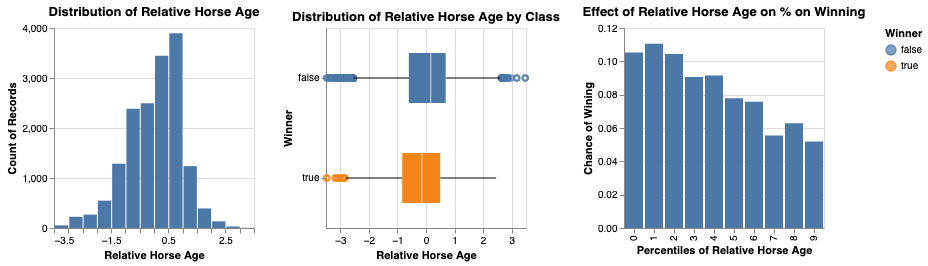

In [26]:
EDA( variable = 'H_Age_norm', text = 'Relative Horse Age')

It seems that younger horses in a race can have a sight advantage over the older horses. Standard scaling will be used for this feature.

### Number of Days since Last Race

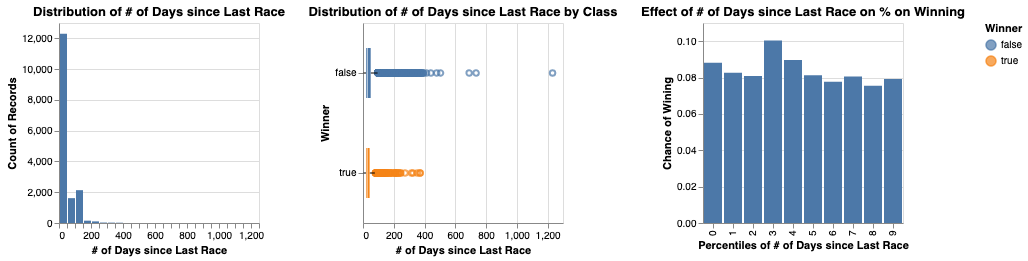

In [27]:
EDA( variable = 'LastRace_nDays', text = '# of Days since Last Race')

Logarithmic transformation is applied as the data is highly positively skewed.

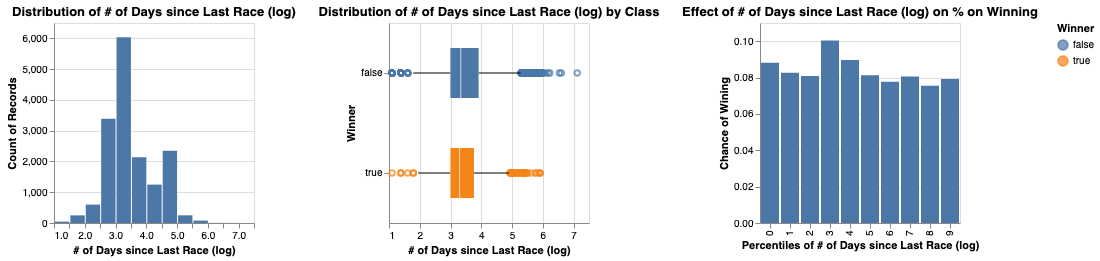

In [28]:
data_full[ 'log_LastRace_nDays'] = np.log( data_full[ 'LastRace_nDays'])
data_full.loc[ data_full[ 'log_LastRace_nDays'] == -np.inf, 'log_LastRace_nDays'] = 0
EDA( variable = 'log_LastRace_nDays', text = '# of Days since Last Race (log)')

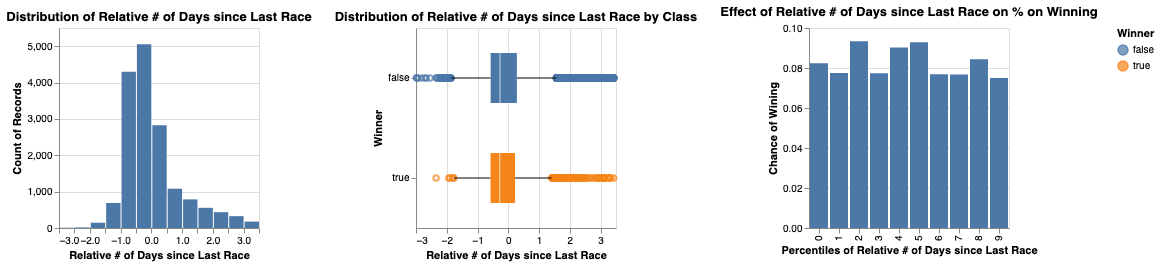

In [29]:
EDA( variable = 'LastRace_nDays_norm', text = 'Relative # of Days since Last Race')

The correlation between number of days since the last race is not obvious. For the absolute number of days, standard scaling will be used after logarithmic transformatio is applied.

### Place in Previous Races

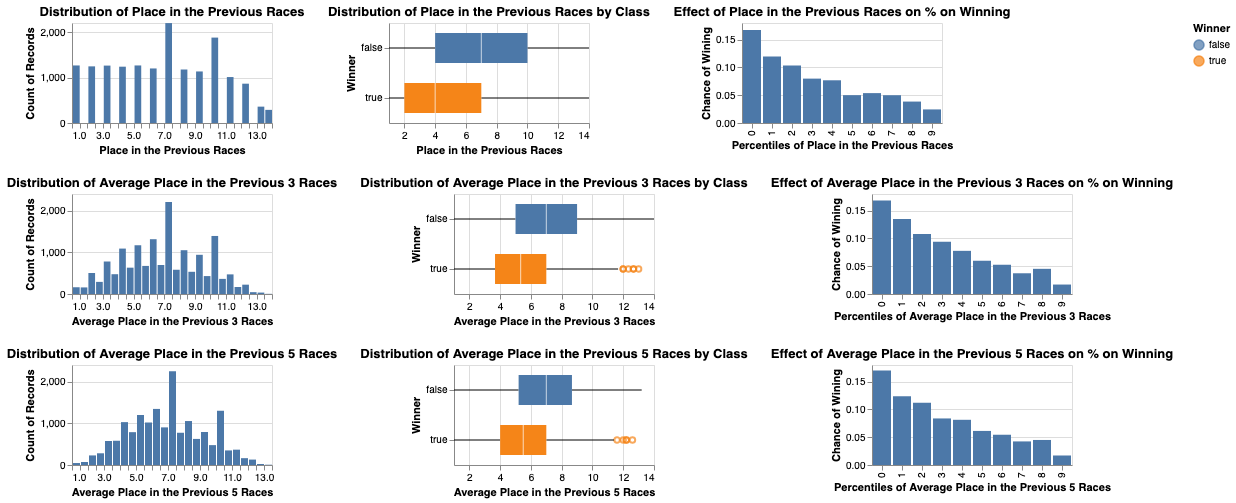

In [30]:
EDA( variable = 'PreviousPlace', text = 'Place in the Previous Races', size = 30, height = 100) & (
    EDA( variable = 'AvgPlace3', text = 'Average Place in the Previous 3 Races', size = 30, height = 100)) & (
        EDA( variable = 'AvgPlace5', text = 'Average Place in the Previous 5 Races', size = 30, height = 100))

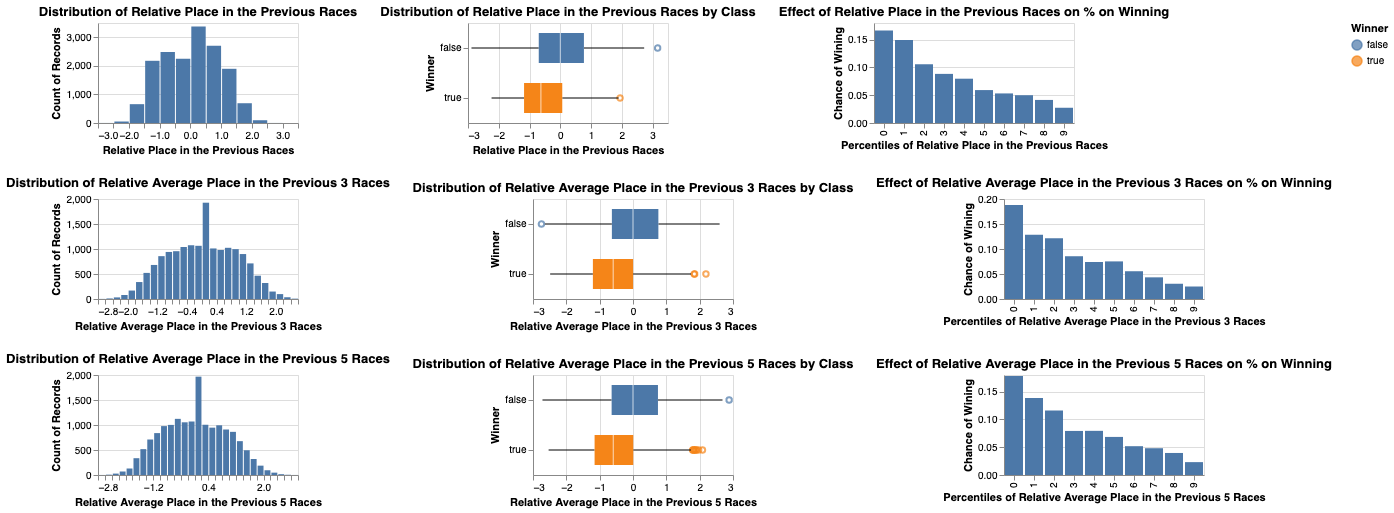

In [31]:
EDA( variable = 'PreviousPlace_norm', text = 'Relative Place in the Previous Races', size = 30, height = 100) & (
    EDA( variable = 'AvgPlace3_norm', text = 'Relative Average Place in the Previous 3 Races', size = 30, height = 100)) & (
        EDA( variable = 'AvgPlace5_norm', text = 'Relative Average Place in the Previous 5 Races', size = 30, height = 100))

Winners seem to have better historical results in the past races. The absolute places will be scaled with a standard scaler when used.

### Change in Horse Weight

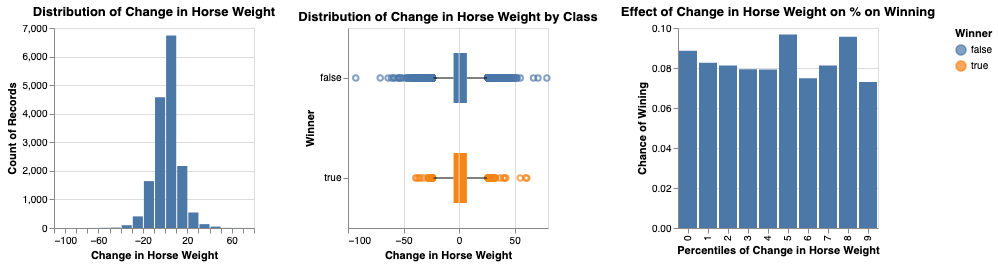

In [32]:
EDA( variable = 'WeightDiff', text = 'Change in Horse Weight')

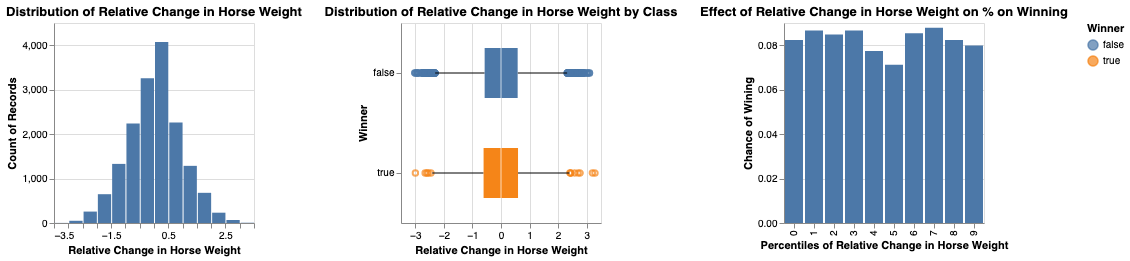

In [33]:
EDA( variable = 'WeightDiff_norm', text = 'Relative Change in Horse Weight')

Changes in horse weight does not seem to correlated with winning rates. Standard scaling will be used if the feature is included in the models.

### Rating

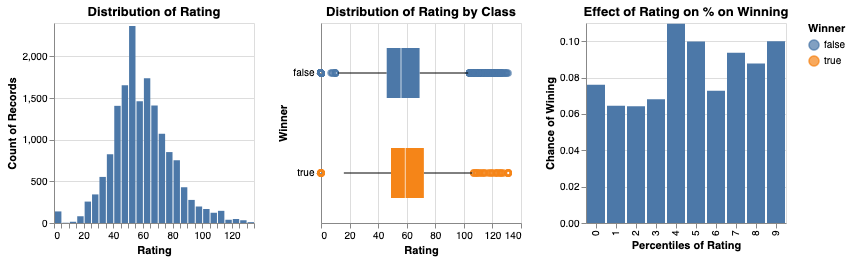

In [34]:
EDA( variable = 'CombinedRating', text = 'Rating')

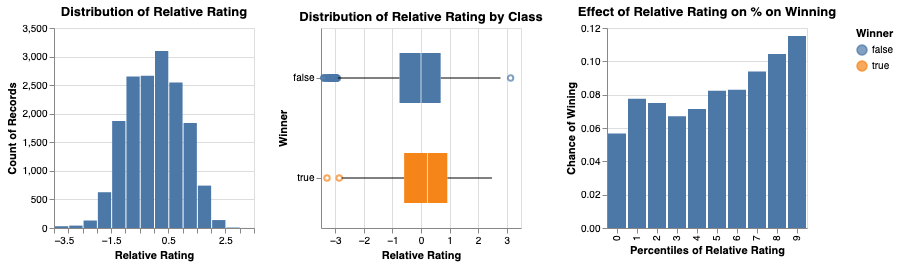

In [35]:
EDA( variable = 'CombinedRating_norm', text = 'Relative Rating')

Winners seem to have higher ratings. Standard scaling will be applied for the absolute rating.